In [2]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import DataLoader
from sentence_transformers import SentenceTransformer, InputExample, losses, util, models
from sklearn.metrics import accuracy_score


# **Load datasets**

train dataset

In [3]:
TRAIN_PATH = "/content/synthetic_data_for_contrastive_learning.jsonl"
train_df = pd.read_json(TRAIN_PATH, lines=True)
train_df = train_df.dropna(subset=["anchor_story", "similar_story", "dissimilar_story"])

print("Synthetic contrastive samples:", len(train_df))
train_df.head()


Synthetic contrastive samples: 1897


,model_name,anchor_story,similar_story,dissimilar_story
0,meta-llama/Meta-Llama-3.1-8B-Instruct-Turbo,"A mysterious individual, known only by their a...","In the secluded hamlet of Ravenshire, a myster...","In the coastal city of Tidal Cove, a reclusive..."
1,gpt-4o,A mysterious drifter arrives in the lawless fr...,A lone wanderer arrives in the turbulent minin...,"In a sprawling, rain-soaked city, a quiet mech..."
2,OpenAI GPT4o Mini,"A team of paranormal investigators, led by sea...","A group of spectral researchers, led by experi...","In a bustling modern city, a group of amateur ..."
3,OpenAI GPT 5 Chat,A prolonged drought devastates a rural farming...,A severe heatwave grips the remote farming set...,"In a remote coastal town, a series of mysterio..."
4,meta-llama/Meta-Llama-3.1-8B-Instruct-Turbo,The film revolves around a Marine who is sever...,The film follows Gunnery Sergeant Ryder Thomps...,"In a dystopian future, Captain Rachel Kim, a r..."


dev dataset

In [6]:
DEV_B_PATH = "/content/dev_track_b.jsonl"
dev_b_df = pd.read_json(DEV_B_PATH, lines=True)

print("Dev Track B samples:", len(dev_b_df))
dev_b_df.head()


Dev Track B samples: 479


,text
0,The old grandmother Tina arrives in town to at...
1,The nano-plague that poisoned Earth's water su...
2,The book follows an international organization...
3,"Bill Babbitt supported the death penalty, unti..."
4,A white-collar suburban father Kyle (Fran Kran...


In [7]:
train_examples = []

for _, row in train_df.iterrows():
    anchor = row["anchor_story"]
    pos    = row["similar_story"]
    neg    = row["dissimilar_story"]

    train_examples.append(InputExample(texts=[anchor, pos, neg]))

len(train_examples)


1897

In [8]:
train_dataloader = DataLoader(train_examples, shuffle=True, batch_size=16)


# **SBERT Fine-Tune model**




In [11]:
import os
os.environ["WANDB_DISABLED"] = "true"
os.environ["WANDB_MODE"] = "offline"
os.environ["DISABLE_WANDB"] = "true"


In [12]:
b2_model = SentenceTransformer("all-MiniLM-L6-v2")

triplet_loss_b2 = losses.TripletLoss(
    model=b2_model,
    distance_metric=losses.SiameseDistanceMetric.COSINE_DISTANCE,
    triplet_margin=0.3
)


train

In [13]:
b2_model.fit(
    train_objectives=[(train_dataloader, triplet_loss_b2)],
    epochs=1,
    warmup_steps=int(len(train_dataloader)*0.1),
    show_progress_bar=True
)


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Computing widget examples:   0%|          | 0/1 [00:00<?, ?example/s]

Step,Training Loss


generate embedding for dev set

In [14]:
b2_embeddings = b2_model.encode(
    dev_texts,
    convert_to_numpy=True,
    batch_size=64,
    show_progress_bar=True
)

np.save("track_b_b2.npy", b2_embeddings)
print("B2 embeddings saved:", b2_embeddings.shape)


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

B2 embeddings saved: (479, 384)


# **DeBERTa Sentence Transformer**

In [15]:
deberta_name = "microsoft/deberta-v3-base"

word_encoder = models.Transformer(deberta_name, max_seq_length=256)
pooler = models.Pooling(word_encoder.get_word_embedding_dimension())

b3_model = SentenceTransformer(modules=[word_encoder, pooler])


config.json:   0%|          | 0.00/579 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/371M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/371M [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/transformers/convert_slow_tokenizer.py:566: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


In [16]:
b3_loader = DataLoader(train_examples, shuffle=True, batch_size=8)


In [17]:
triplet_loss_b3 = losses.TripletLoss(
    model=b3_model,
    distance_metric=losses.SiameseDistanceMetric.COSINE_DISTANCE,
    triplet_margin=0.3
)


train

In [18]:
b3_model.fit(
    train_objectives=[(b3_loader, triplet_loss_b3)],
    epochs=1,
    warmup_steps=int(len(b3_loader) * 0.1),
    show_progress_bar=True
)


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Computing widget examples:   0%|          | 0/1 [00:00<?, ?example/s]

Step,Training Loss


generate embeddings for dev set

In [19]:
b3_embeddings = b3_model.encode(
    dev_texts,
    convert_to_numpy=True,
    batch_size=16,
    show_progress_bar=True
)

np.save("track_b_b3.npy", b3_embeddings)
print("B3 embeddings saved:", b3_embeddings.shape)


Batches:   0%|          | 0/30 [00:00<?, ?it/s]

B3 embeddings saved: (479, 768)


In [20]:
print("Embedding dimensions:")
print("B1:", b1_embeddings.shape)
print("B2:", b2_embeddings.shape)
print("B3:", b3_embeddings.shape)


Embedding dimensions:
B1: (479, 384)
B2: (479, 384)
B3: (479, 768)


Cosine similarity plot

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from sentence_transformers.util import cos_sim


In [25]:
sim_b2 = cos_sim(b2_embeddings, b2_embeddings).cpu().numpy()
sim_b3 = cos_sim(b3_embeddings, b3_embeddings).cpu().numpy()


In [26]:
def flatten_upper(matrix):
    i, j = np.triu_indices(matrix.shape[0], k=1)
    return matrix[i, j]

flat_b2 = flatten_upper(sim_b2)
flat_b3 = flatten_upper(sim_b3)


/tmp/ipython-input-2962878096.py:5: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(flat_b2, label="Fine-tuned SBERT", shade=True, color="#55A868")
/tmp/ipython-input-2962878096.py:6: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(flat_b3, label="DeBERTa Triplet", shade=True, color="#C44E52")


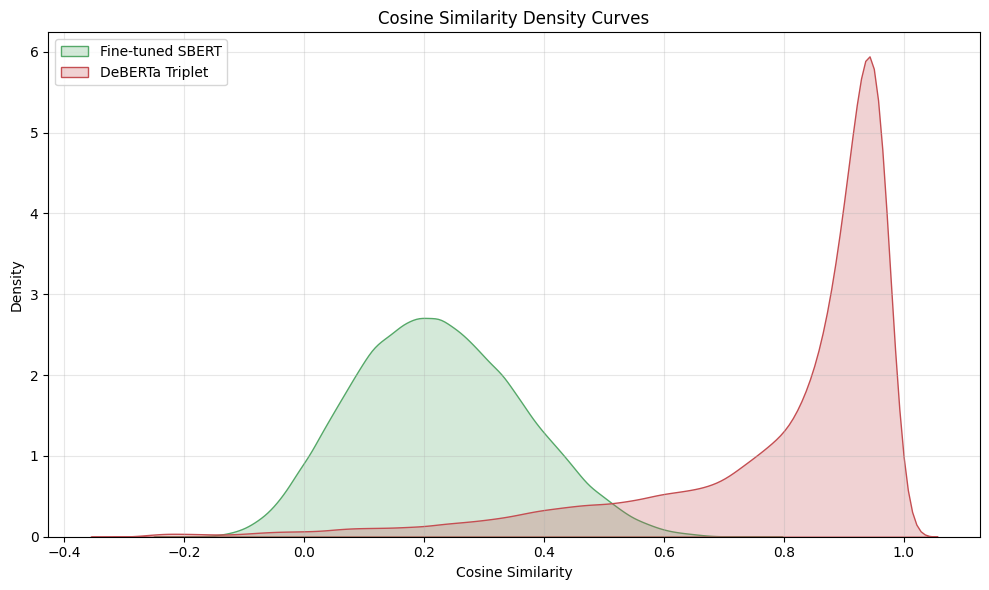

In [32]:
import seaborn as sns

plt.figure(figsize=(10,6))

sns.kdeplot(flat_b2, label="Fine-tuned SBERT", shade=True, color="#55A868")
sns.kdeplot(flat_b3, label="DeBERTa Triplet", shade=True, color="#C44E52")

plt.title("Cosine Similarity Density Curves")
plt.xlabel("Cosine Similarity")
plt.ylabel("Density")
plt.legend()
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()
